
# Sentinel-1 Radar imagergy <img align="right" src="../Supplementary_data/EY_logo.png" style="margin:0px 50px">


Radar imagery can be used as a complementary dataset for Challenge 2. 

Radar is an active measurement technique, illuminating the Earth's surface and detecting the light scattering effects, rather than relying on the sun to illuminate the Earth, such as in passive, optical techniques. Synthetic Aperture Radar (SAR) is a form of radar often used on satellites, where the motion of the satellite over the landscape allows for higher spatial resolution measurements to be obtained. SAR measurements can penetrate cloud and smoke cover, making it particularly useful for assessing bushfires, and can also operate at night.

The European Space Agency (ESA)'s Sentinel-1 mission consists of two satellites: Sentinel-1A (launched in 2014) and Sentinel-1B (launched in 2016). Each houses an SAR instrument on board. These instruments provide single C-band 1 dB radiometric accuracy with a central frequency at 5.405 GHz. 

Together, the Sentinel-1 satellites provide:
- global coverage 
- frequent imaging (the satellites have a frequent revisit time of 6 days.)
- different polarizations to capture different geospatial properties (e.g., VV, VH, as explained further below)
- and can detect millimetre changes in elevation.

This notebook explores the Sentinel-1 datasets. You can use these in your analysis to assist with the fire progression prediction in Chanllenge 2. 

As an example, this notebook shows what information we can obtain from the Sentinel-1 Radio Terrain Correction (RTC) gamma-0 data product `s1_rtc`.  The RTC gamma-0 data are corrected for variations caused by changing observation geometries.

### Import libraries

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import Image
from datacube import Datacube
import numpy as np
import xarray as xr

import sys
sys.path.append("../scripts")
import pandas as pd
from dea_plotting import display_map
from dea_plotting import rgb

/env/lib/python3.6/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.7.2-CAPI-1.11.0 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


<!-- ### Set up distributed computing

Calculating the maximum value for each pixel in an image can be computationally expensive. However, it is possible to reduce the computation time by parallelising the process through Dask. Access to Dask is provided in the Azure environment. 

For more information about using Dask, refer to the Parallel processing with Dask notebook.

To set up distributed computing with Dask, you need to first set up a Dask client using the function below: -->

### Load Sentinel-1 data

In [2]:
# instantiate a datacube object
dc = Datacube(app="Sentinel-1 example")

In [3]:
# locate the Sentinel-1 RTC product dataset
senti_datasets = dc.find_datasets(product='s1_rtc')
senti_datasets = sorted(senti_datasets, 
                        key = lambda ds: (ds.center_time, ds.id))

# check available information for a random dataset
sample = senti_datasets[100]
print(sample, '\n')
print('sample_0 metadata_label: ', sample.metadata_doc['label'])
print(f'\nNumber of s1_rtc datasets: {len(senti_datasets)}')

Dataset <id=e320bae8-996e-56ea-ae68-0efbefa47e9a product=s1_rtc location=https://geoau.blob.core.windows.net/ey-gsa/sentinel-1/s1_ey/s1_rtc/S37E141/2018/01/11/0224A9/s1_rtc_0224A9_S37E141_2018_01_11_metadata.json> 

sample_0 metadata_label:  S37E141_2018_01_11_0224A9

Number of s1_rtc datasets: 4318


In [4]:
# read other infomation in the metadata
sample.metadata_doc

{'id': 'e320bae8-996e-56ea-ae68-0efbefa47e9a',
 'crs': 'epsg:4326',
 'grids': {'default': {'shape': [5000, 5000],
   'transform': [141.0, 0.0002, 0.0, -36.0, 0.0, -0.0002]}},
 'label': 'S37E141_2018_01_11_0224A9',
 'extent': {'lat': {'end': -36.0, 'begin': -37.0},
  'lon': {'end': 142.0, 'begin': 141.0}},
 '$schema': 'https://schemas.opendatacube.org/dataset',
 'lineage': {'source_datasets': {}},
 'product': {'name': 's1_rtc'},
 'geometry': {'type': 'Polygon',
  'coordinates': [[[141.0, -37.0],
    [142.0, -37.0],
    [142.0, -36.0],
    [141.0, -36.0],
    [141.0, -37.0]]]},
 'properties': {'datetime': '2018-01-11T19:49:02.064896Z',
  'proj:epsg': 4326,
  'eo:platform': 'sentinel-1a',
  'odc:product': 's1_rtc',
  'eo:instrument': 'C-SAR',
  'odc:file_format': 'GeoTIFF',
  'odc:region_code': 'S37E141',
  'sat:orbit_state': 'descending',
  'dtr:end_datetime': '2018-01-11T19:49:53.336518Z',
  'eo:constellation': 'sentinel-1',
  'sar:product_type': 'RTC',
  'sar:polarizations': ['VV', 'VH

You can use the metadata to match your training data, e.g., by coordinates and datetime properties. This is part of the challenge! Here we load a random single radar image to learn about its features.

In [5]:
# load the Sentinel-1 backscatter data
s1 = dc.load(product='s1_rtc', 
             id='e320bae8-996e-56ea-ae68-0efbefa47e9a', 
             output_crs='epsg:4326', 
             resolution=(-0.0002,0.0002))

In [6]:
print(s1)

<xarray.Dataset>
Dimensions:      (latitude: 5000, longitude: 5000, time: 1)
Coordinates:
  * time         (time) datetime64[ns] 2018-01-11T19:49:27.700707
  * latitude     (latitude) float64 -36.0 -36.0 -36.0 ... -37.0 -37.0 -37.0
  * longitude    (longitude) float64 141.0 141.0 141.0 ... 142.0 142.0 142.0
    spatial_ref  int32 4326
Data variables:
    vv           (time, latitude, longitude) float32 0.014688958 ... 0.09168618
    vh           (time, latitude, longitude) float32 0.0050381557 ... 0.05534...
    angle        (time, latitude, longitude) uint8 40 40 40 40 ... 32 36 36 32
    area         (time, latitude, longitude) float32 1.2194388 ... 1.5973088
    mask         (time, latitude, longitude) uint8 1 1 1 1 1 1 1 ... 1 1 1 1 1 1
Attributes:
    crs:           epsg:4326
    grid_mapping:  spatial_ref


In [7]:
id = 'e320bae8-996e-56ea-ae68-0efbefa47e9a'
selected_id = [ds for ds in senti_datasets if ds.metadata_doc['id'] == id]

# extract latitude, longtitude, and datetime information 
lat_dict = selected_id[0].metadata_doc['extent']['lat']
lon_dict = selected_id[0].metadata_doc['extent']['lon']
dt_string = selected_id[0].metadata_doc['properties']['datetime']

In [8]:
latitude = (lat_dict['begin'], lat_dict['end'])
longitude = (lon_dict['begin'], lon_dict['end'])

###  View the selected location intractively
The next cell will display the selected area on an interactive map. Feel free to zoom in and out to get a better understanding of the area you’ll be analysing. Clicking on any point of the map will reveal the latitude and longitude coordinates of that point.

In [9]:
display_map(x=longitude, y=latitude)

### Visualise loaded data in different channels

Sentinel-1 backscatter data has two measurements, VV and VH, which correspond to the polarisation of the light sent and received by the satellite. VV refers to the satellite sending out vertically-polarised light and receiving vertically-polarised light back, whereas VH refers to the satellite sending out vertically-polarised light and receiving horizontally-polarised light back. These two measurement bands can tell us different information about the area we’re studying.

The Co-polarisation (VV) channel is indicative of surface scattering such as soil, rock and corner relections from buildings. Relatively smooth surfaces such as water and bare grounds have very little backscatter and will appear black in the image.

Cross-polarisation (VH) channel is indicative of volume scattering. It can be used to separte vegetated areas and non-vegetated areas. Water, bare soil and rock will also appear black in the VH images. Vegetated areas have larger volume scattering and will appear brighter.

The ratio of the VV and VH channel is used to highlight the similarity and discrepancy of the two channels. The ratio image provides a higher contrast for areas where the surface scattering and volume scattering act differently. For example, vegetated areas will have a high VH/VV value, whereas bare grounds will have a low VH/VV value. 

In [10]:
# add two VH/VV and VV/VH ratio channels
s1["vv_vh"] = s1.vv/s1.vh
s1["vh_vv"] = s1.vh/s1.vv

# add normalised channels for making RGB images below
s1["vv_r"] = s1.vv/s1.vv.mean()
s1["vh_g"] = s1.vh/s1.vh.mean()
s1["vhvv_b"] = s1.vh_vv/s1.vh_vv.mean()

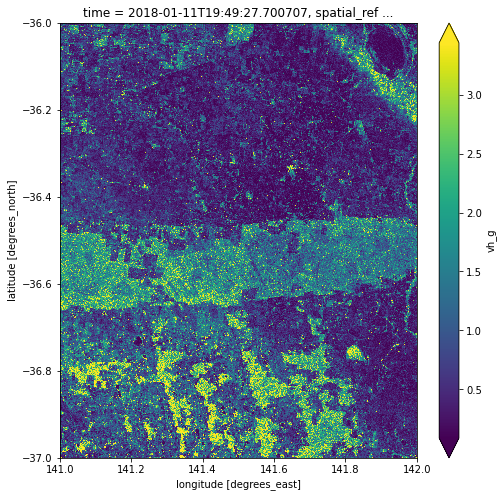

In [11]:
# Plot the VH observation
s1.vh_g.plot(cmap="viridis", robust=True, figsize=(8, 8))
plt.show()

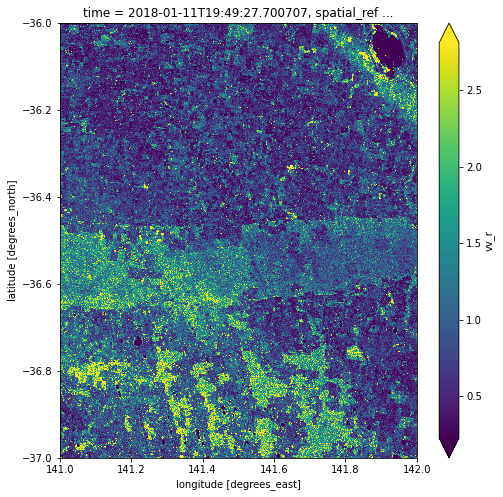

In [12]:
# Plot the VV observation
s1.vv_r.plot(cmap="viridis", robust=True, figsize=(8, 8))
plt.show()

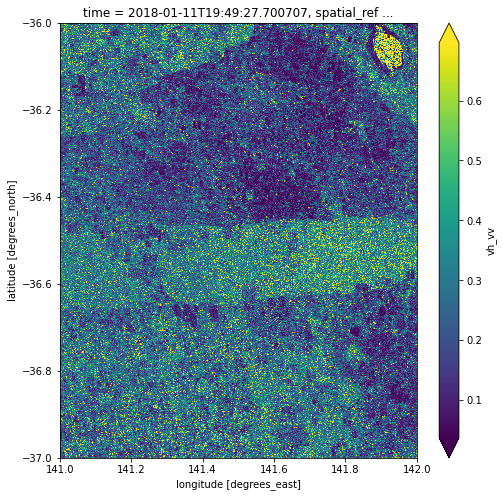

In [13]:
# Plot the VH/VH ration image
s1.vh_vv.plot(cmap="viridis", robust=True, figsize=(8, 8))
plt.show()

### Make a false-color composite image

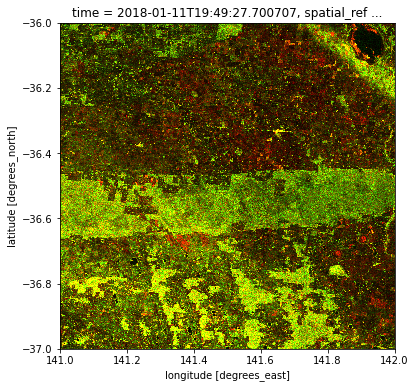

In [14]:
# method 1
s1[["vv_r", "vh_g", "vhvv_b"]].isel(time=0).to_array().plot.imshow(robust=True, figsize=(6, 6))

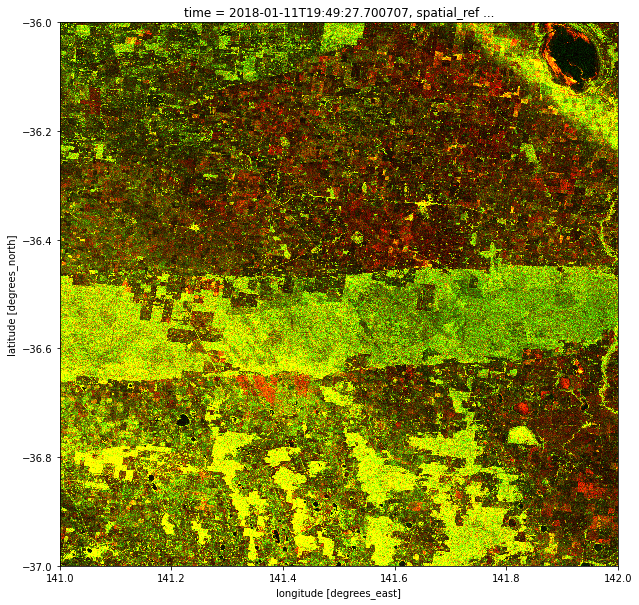

In [15]:
# method 2
# normalise the datacube so that RGB channels are in a similar range
red_arr = xr.DataArray(s1.vv) / np.nanmean(xr.DataArray(s1.vv))
green_arr = xr.DataArray(s1.vh) / np.nanmean(xr.DataArray(s1.vh))
blue_arr = xr.DataArray(s1.vh_vv) / np.nanmean(xr.DataArray(s1.vh_vv))
composite_arr = xr.Dataset({'red': red_arr,
                           'green': green_arr,
                           'blue': blue_arr})
rgb(composite_arr, 
    bands=['red', 'green', 'blue'], 
    size=10, index=0,
    percentile_stretch = [0.05, 0.95])
plt.show()

### Conclusion
The red colors in the RGB images highlight regions of bare soil or rock (high VV values, low VH and VH/VV values).  The blue areas are low VV and high VH values, indicative of vegetated regions. The dark areas could indicate water. These images can help trace the effect of fire before and after a disaster.

Other examples about using the Sentinel-1 data, including making use of
the parallel-computing library `Dask` can be found here:
https://docs.dea.ga.gov.au/notebooks/Real_world_examples/Shipping_lane_identification.html

***
## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please review the FAQ section and support options on the [EY Data Science Platform](https://datascience.ey.com/).